# Modelo de agrupamiento

### Librerias

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt

from scipy.stats import boxcox, zscore
from scipy.special import inv_boxcox

from sklearn.experimental import enable_iterative_imputer
#from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans

### Cargar Datos Procesados

In [20]:
data = pd.read_csv('data_processing.csv')
data.head()

,Education,Marital_Status,Income,Kids,Recency,Expenses,Cus_age,TotalPurchases,TotalAcceptedCamp,Complain,Response
0,Universitario,Solo,58138.0,0,58,1617,55,25,0,0,1
1,Universitario,Solo,46344.0,2,38,27,60,6,0,0,0
2,Universitario,Pareja,71613.0,0,26,776,48,21,0,0,0
3,Universitario,Pareja,26646.0,1,26,53,30,8,0,0,0
4,Posgrado,Pareja,58293.0,1,94,422,33,19,0,0,0


### Convertir variables categoricas a numericas

Creamos una copia del dataframe

In [21]:
df = data.copy()

Seleccionamos las caracteristicas de tipo categorica

In [22]:
var_category = df.select_dtypes(include='object').columns.to_list()
var_category

['Education', 'Marital_Status']

convertimos a valores numericos

In [23]:
x_enconded = pd.get_dummies(df, columns=var_category, drop_first=True, dtype=int)
x_enconded.head()

,Income,Kids,Recency,Expenses,Cus_age,TotalPurchases,TotalAcceptedCamp,Complain,Response,Education_Posgrado,Education_Universitario,Marital_Status_Solo
0,58138.0,0,58,1617,55,25,0,0,1,0,1,1
1,46344.0,2,38,27,60,6,0,0,0,0,1,1
2,71613.0,0,26,776,48,21,0,0,0,0,1,0
3,26646.0,1,26,53,30,8,0,0,0,0,1,0
4,58293.0,1,94,422,33,19,0,0,0,1,0,0


Verificamos que todas las variables sean numericas

In [24]:
x_enconded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Income                   2016 non-null   float64
 1   Kids                     2016 non-null   int64  
 2   Recency                  2016 non-null   int64  
 3   Expenses                 2016 non-null   int64  
 4   Cus_age                  2016 non-null   int64  
 5   TotalPurchases           2016 non-null   int64  
 6   TotalAcceptedCamp        2016 non-null   int64  
 7   Complain                 2016 non-null   int64  
 8   Response                 2016 non-null   int64  
 9   Education_Posgrado       2016 non-null   int64  
 10  Education_Universitario  2016 non-null   int64  
 11  Marital_Status_Solo      2016 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 189.1 KB


### Normalizar los datos

In [29]:
# instanciamos el objeto StandarScaler
scale = StandardScaler()
# normalizamos los datos
x_scaled = scale.fit_transform(x_enconded)
# mostrar registros escalados
x_scaled[:]

array([[ 0.31591844, -1.28171455,  0.31644558, ..., -0.78776823,
         0.8288723 ,  1.33155544],
       [-0.25541911,  1.40289484, -0.37357042, ..., -0.78776823,
         0.8288723 ,  1.33155544],
       [ 0.96868879, -1.28171455, -0.78758002, ..., -0.78776823,
         0.8288723 , -0.7510014 ],
       ...,
       [ 0.25986981, -1.28171455,  1.45497198, ..., -0.78776823,
         0.8288723 ,  1.33155544],
       [ 0.8539756 ,  0.06059014, -1.40859442, ...,  1.2694089 ,
        -1.20645846, -0.7510014 ],
       [ 0.06067192,  1.40289484, -0.30456882, ...,  1.2694089 ,
        -1.20645846, -0.7510014 ]])

### Construir el Modelo

El objetivo del proyecto es realizar una segmentacion de los clientes para conocer sus preferencia y de esta forma crear nuevas campañas enfocada en estos grupos.

Vamos a utilizar el modelo KMeans con los siguientes parametros:

- Agrupar los datos en 3 clusteres o grupos. (n_cluster)
- Utilizar el metodo de inicializacion de los centroides (init)
- Ejecutar el modelo 10 veces con diferentes inicializaciones de centroide (n_init)
- Ejecutar un maximo de 300 iteraciones en el que el algoritmo pueda converger (max_iter)


In [30]:
# crear el modelo
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, random_state=42)

Ahora, ajustamos el modelo a los datos escalados

In [31]:
kmeans.fit(x_scaled)

KMeans(n_clusters=3, n_init=10, random_state=42)

Generamos etiquetas que asignan cada muestra a un cluster.

In [32]:
y_kmeans = kmeans.fit_predict(x_scaled)

Finalmente, calculamos la inercia que es una metrica que mide la suma de las distancias cuadradas de cada punto de datos a su centroide más cercano. 

Sirve para evaluar la calidad del clúster; un valor menor de inercia indica clústeres más compactos y bien formados. Sin embargo, la inercia por sí sola no debe ser el único criterio para seleccionar el número de clústeres.

In [33]:
inertia = kmeans.inertia_

### Hiperajuste del Modelo

Para encontrar el numero optimo de clusteres, vamos a utilizar el Metodo del Codo que es una tecnica grafica que nos indica el punto en el que agregar mas clusteres deja de mejorar significativamente la compactacion de los datos, ayudando a evitar el sobreajuste.

Vamos a correr el modelo variando el numero de clusteres y obtener el respectivo valor de inercia para cada uno

In [34]:
# lista para almacenar los valores de inercia
kmeans_inercia = []

# ejecutar el modelo 10 veces con diferente numero de clusteres
for n in np.arange(1,10):
    kmeans = KMeans(n_clusters=n, init='k-means++', n_init=10, max_iter=300, random_state=42)
    kmeans.fit(x_scaled)
    inercia = kmeans.inertia_
    kmeans_inercia.append(inercia)

kmeans_inercia

[24191.999999999993,
 19391.44219271858,
 16980.431120230347,
 15346.820097198433,
 13404.906562498687,
 12192.16573057586,
 11526.292452422334,
 11018.076897459947,
 10566.746825884506]

Ahora, graficamos la incercia en funcion del numero de clusteres

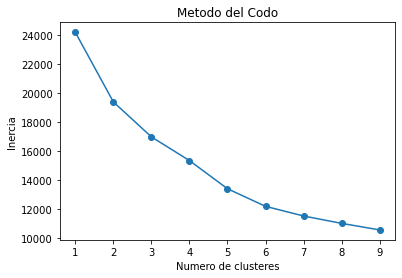

In [35]:
plt.plot(np.arange(1,10), kmeans_inercia, marker='o')
plt.title('Metodo del Codo')
plt.xlabel('Numero de clusteres')
plt.ylabel('Inercia')
plt.show()

> La grafica nos muestra que la inercia va reduciendose a partir de 3 clusteres. Sin embargo, no queda del todo claro si dicha cantidad es la optima. 

Vamos apoyarnos en otro metodo conocido como Silhouette Score para determinar el numero optimo de clusteres. Es una metrica que mide la calidad del agrupamiento midiendo que tan bien estan separados los clusteres y que tan bien ajustados estan los puntos de datos dentro de los clusteres.